<a href="https://colab.research.google.com/github/anniebritton/Ecological-Drought-ML-Modeling/blob/main/NDVI_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Workbook Setup**

In [ ]:
# install and import libraries
!pip install lazypredict
!pip install shap

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Scikit Learn
from sklearn.model_selection import KFold, cross_val_score, train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.utils import shuffle
from scipy.stats import uniform, randint
from sklearn.metrics import mean_squared_error, r2_score

# Models
from sklearn.ensemble import ExtraTreesRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# Other Tools
import lazypredict
from lazypredict.Supervised import LazyRegressor
import shap
from joblib import dump, load

In [ ]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

# **Import Data**

In [ ]:
# Load in and configure the data
normalized_df = pd.read_csv('/content/drive/MyDrive/School/M.S./Courses/Capstone/Colab/Data/CSVs/NDVI_clean_preprocessed_shorttermdrought.csv')
normalized_df['date'] = pd.to_datetime(normalized_df['date'])
normalized_df = normalized_df.set_index('date')

# Get column names that end with "_anomaly_roll"
columns_to_rename = [col for col in normalized_df.columns if col.endswith('_anomaly_roll')]

# Create a mapping of old column names to new column names
rename_dict = {col: col[:-len('_anomaly_roll')].upper() for col in columns_to_rename}

# Rename columns in the DataFrame and capitalize column names
normalized_df.rename(columns=rename_dict, inplace=True)
normalized_df.rename(columns={'TMIN': 'Tmin', 'TMAX': 'Tmax', 'PRECIP': 'Precip', 'PALMERZ': 'PalmerZ',}, inplace=True)

# Check the df
normalized_df

#**Prelim ML Tests**

In [ ]:
# try a decision tree regressor
from sklearn import tree

X = normalized_df.iloc[:,1:16].values
Y = normalized_df.iloc[:,0:1].values.ravel()

clf = tree.DecisionTreeRegressor()

X_train = normalized_df.iloc[0:1272, 1:16].values
Y_train = normalized_df.iloc[0:1272, 0:1].values.ravel()
X_test = normalized_df.iloc[1272:1590, 1:16].values
Y_test = normalized_df.iloc[1272:1590, 0:1].values

clf.fit(X_train, Y_train)
Y_predicted = clf.predict(X_test)

# compare Y_predicted with Y_test
clf.score(X_test, Y_test)

In [ ]:
# try support vector regression
from sklearn import svm

X = normalized_df.iloc[:,1:16].values
Y = normalized_df.iloc[:,0:1].values.ravel()

regr = svm.SVR()

X_train = normalized_df.iloc[0:1272, 1:16].values
Y_train = normalized_df.iloc[0:1272, 0:1].values.ravel()
X_test = normalized_df.iloc[1272:1590, 1:16].values
Y_test = normalized_df.iloc[1272:1590, 0:1].values

regr.fit(X_train, Y_train)
Y_predicted = regr.predict(X_test)

# compare Y_predicted with Y_test
regr.score(X_test, Y_test)

#**Simple K-Fold Cross Validation for LazyPredict Regression**

In [ ]:
# Define our x and y variables
X = normalized_df.iloc[:, 1:16].values
y = normalized_df.iloc[:, 0:1].values.ravel()

In [ ]:
def k_fold_lp(data, target, k=5):
    # Create a KFold object with k folds
    kf = KFold(n_splits=k, shuffle = True, random_state=42)
    # Create an empty df to store scores for each fold
    scores = pd.DataFrame()
    # Loop over each fold
    for train_idx, test_idx in kf.split(data):
        # Split the data into train and test sets for this fold
        X_train, X_test = data[train_idx], data[test_idx]
        y_train, y_test = target[train_idx], target[test_idx]
        # Create a LazyRegressor model
        reg = LazyRegressor(verbose=0, ignore_warnings=False, custom_metric=None)
        # Fit the model on the train data and make predictions on the test data
        models, predictions = reg.fit(X_train, X_test, y_train, y_test)
        # Append the score to the list of scores for this fold
        scores = scores.append(predictions)
    # Calculate the mean of all scores across all folds
    return scores

In [ ]:
mean_score = k_fold_lp(X, y)
mean_score = mean_score.sort_values(by = "Adjusted R-Squared", ascending = False)

In [ ]:
mean_score.groupby("Model").mean().sort_values(by = "Adjusted R-Squared", ascending = False)

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
ExtraTreesRegressor,0.93,0.93,0.26,0.65
GaussianProcessRegressor,0.92,0.93,0.27,0.23
LGBMRegressor,0.89,0.90,0.32,0.20
HistGradientBoostingRegressor,0.89,0.89,0.32,0.57
XGBRegressor,0.89,0.89,0.33,0.57
RandomForestRegressor,0.88,0.88,0.34,1.67
BaggingRegressor,0.85,0.86,0.37,0.18
KNeighborsRegressor,0.81,0.82,0.42,0.04
GradientBoostingRegressor,0.78,0.79,0.45,0.78


#**Determining the Test Fold**

We can quickly run cross validation without shuffle across 5 folds of our entire dataset to see which 20% performs closest to the average.

In [ ]:
# Define our x and y variables
X = normalized_df.iloc[:, 1:16].values
y = normalized_df.iloc[:, 0:1].values.ravel()

# Define your model
etr_model = ExtraTreesRegressor(random_state=42)

# Define the number of folds for cross validation
num_folds = 5

# Define the k-fold cross validation object
kfold = KFold(n_splits=num_folds, shuffle=False)

# Run k-fold cross validation on the model
results = cross_val_score(etr_model, X, y, cv=kfold, scoring='r2')

# Print the cross validation and test results
print("Test Set Results:", results)
print("Test Set Mean Result:", results.mean())

Test Set Results: [0.5315005  0.55270563 0.52870312 0.23788574 0.46805681]
Test Set Mean Result: 0.4637703610228286


In [ ]:
# Define your model
xgb_model = XGBRegressor(random_state=42)

# Define the number of folds for cross validation
num_folds = 5

# Define the k-fold cross validation object
kfold = KFold(n_splits=num_folds, shuffle=False)

# Run k-fold cross validation on the model
results = cross_val_score(xgb_model, X, y, cv=kfold, scoring='r2')

# Print the cross validation and test results
print("Test Set Results:", results)
print("Test Set Mean Result:", results.mean())

Test Set Results: [0.50076618 0.42467948 0.4241503  0.13552309 0.41893699]
Test Set Mean Result: 0.3808112059038776


Since the last folds tend to perform closest to the mean result of all five folds, we will select the last 20% of the data for testing (convienient!).

# **Train Test Split**

In [ ]:
# Based on our results above, select the last 20% of the data to be our test set
# Define our x and y variables
X = normalized_df.iloc[:, 1:16].values
y = normalized_df.iloc[:, 0:1].values.ravel()

# Split up the test and training data
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

print("Training data shape - x_train: ", x_train.shape)
print("Training data shape - y_train: ", y_train.shape)
print("Testing data shape - x_test: ", x_test.shape)
print("Testing data shape - y_test: ", y_test.shape)

Training data shape - x_train:  (1272, 15)
Training data shape - y_train:  (1272,)
Testing data shape - x_test:  (318, 15)
Testing data shape - y_test:  (318,)


#**Baseline Models**

In [ ]:
# Define your model
etr_model = ExtraTreesRegressor(random_state=42)

# Define the number of folds for cross validation
num_folds = 5

# Define the k-fold cross validation object
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Run k-fold cross validation on the model
results = cross_val_score(etr_model, x_train, y_train, cv=kfold, scoring='r2')

# Fit the model to the training data
etr_model.fit(x_train, y_train)

# Use the trained model to make predictions on the test data
y_pred = etr_model.predict(x_test)

# Calculate the model performance metrics on the test data
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Print the cross validation and test results
print("Cross Val Results:", results)
print("Cross Val Mean Result:", results.mean())

print('Test Mean Squared Error:', mse)
print('Test Root Mean Squared Error:', rmse)
print('Test R-squared:', r2)

Cross Val Results: [0.92448104 0.94321891 0.93044046 0.94259361 0.92063844]
Cross Val Mean Result: 0.9322744938539509
Test Mean Squared Error: 0.5537734887298728
Test Root Mean Squared Error: 0.7441595855257612
Test R-squared: 0.4680568138118374


In [ ]:
# Define your model
xgb_model = XGBRegressor(random_state=42)

# Define the number of folds for cross validation
num_folds = 5

# Define the k-fold cross validation object
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Run k-fold cross validation on the model
results = cross_val_score(xgb_model, x_train, y_train, cv=kfold, scoring='r2')

# Fit the model to the training data
xgb_model.fit(x_train, y_train)

# Use the trained model to make predictions on the test data
y_pred = xgb_model.predict(x_test)

# Calculate the model performance metrics on the test data
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Print the cross validation and test results
print("Cross Val Results:", results)
print("Cross Val Mean Result:", results.mean())

print('Test Mean Squared Error:', mse)
print('Test Root Mean Squared Error:', rmse)
print('Test R-squared:', r2)

Cross Val Results: [0.87768216 0.90339653 0.89696425 0.85301072 0.87576512]
Cross Val Mean Result: 0.8813637566409692
Test Mean Squared Error: 0.6049091344934824
Test Root Mean Squared Error: 0.777759046552004
Test R-squared: 0.41893698614064967


#**Hyperparameter Optimization** - Random Search

In [ ]:
# Define the distribution of hyperparameters to search over
param_dist = {
    'n_estimators': range(100, 2000, 50),
    'max_depth':  [None] + list(range(5, 51, 3)),
    'min_samples_split': range(1, 21),
    'min_samples_leaf': range(1, 21),
    'max_features': [1.0],
    'bootstrap': [False, True],
}

# Define the regression model
etr = ExtraTreesRegressor(random_state=42)

# Define the number of folds for cross validation
num_folds = 5

# Define the k-fold cross validation object
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Define the random search object
random_search = RandomizedSearchCV(etr, param_distributions=param_dist, cv=kfold, n_iter=50, random_state=42, verbose=3)

# Fit the random search to the training data
random_search.fit(x_train, y_train)

# Predict the test data using the best trained model
best_model = random_search.best_estimator_
y_pred = best_model.predict(x_test)

# Calculate R2 score on the predicted test data
r2 = r2_score(y_test, y_pred)

# Print the best hyperparameters and best score, and R2 score from the test set
print("Best hyperparameters: ", random_search.best_params_)
print("Best score: ", random_search.best_score_)
print("R2 Score: ", r2)

In [ ]:
# Define the distribution of hyperparameters to search over
param_dist = {
    'learning_rate': uniform(0.01, 0.04),
    'max_depth': randint(6, 9),
    'min_child_weight': randint(5, 7),
    'subsample': uniform(0.3, 0.65),
    'colsample_bytree': uniform(0.3, .75),
    'n_estimators': randint(1000, 2500)
}

# Define the regression model
xgb = XGBRegressor(random_state=42)

# Define the number of folds for cross validation
num_folds = 5

# Define the k-fold cross validation object
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Define the random search object
random_search = RandomizedSearchCV(xgb, param_distributions=param_dist, cv=kfold, n_iter=100, random_state=42, verbose=3)

# Fit the random search to the training data
random_search.fit(x_train, y_train)

# Predict the test data using the best trained model
best_model = random_search.best_estimator_
y_pred = best_model.predict(x_test)

# Calculate R2 score on the predicted test data
r2 = r2_score(y_test, y_pred)

# Print the best hyperparameters and best score, and R2 score from the test set
print("Best hyperparameters: ", random_search.best_params_)
print("Best score: ", random_search.best_score_)
print("R2 Score: ", r2)

#**Hyperparameter Optimization** - Grid Search

In [ ]:
# Define the distribution of hyperparameters to search over
param_dist = {
    'n_estimators': [825, 830, 840, 850, 860, 870, 875, 880, 900, 910],
    'max_depth': [15, 16, 17, 18],
    'min_samples_split': [2],
    'min_samples_leaf': [1],
    'max_features': [1.0],
    'bootstrap': [False],
}

# Define the regression model
etr = ExtraTreesRegressor()

# Define the number of folds for cross validation
num_folds = 5

# Define the k-fold cross validation object
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Define the search object
grid_search = GridSearchCV(etr, param_dist, cv=kfold, verbose = 3)

# Fit the grid search to the training data
grid_search.fit(x_train, y_train)

# Predict the test data using the best trained model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(x_test)

# Calculate R2 score on the predicted test data
r2 = r2_score(y_test, y_pred)

# Print the best hyperparameters and best score, and R2 score from the test set
print("Best hyperparameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)
print("R2 Score: ", r2)

In [ ]:
# Define the distribution of hyperparameters to search over
param_dist = {
    'learning_rate': [.027, .031, .035],
    'max_depth': [7],
    'min_child_weight': [3, 4, 5],
    'subsample': [0.60, 0.62, 0.64],
    'colsample_bytree': [0.72, 0.75, 0.78],
    'n_estimators': [925, 950, 975]
}


# Define the regression model
xgb = XGBRegressor(objective='reg:squarederror')

# Define the number of folds for cross validation
num_folds = 5

# Define the k-fold cross validation object
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Define the search object
grid_search = GridSearchCV(xgb, param_dist, cv=kfold, verbose = 3)

# Fit the grid search to the training data
grid_search.fit(x_train, y_train)

# Predict the test data using the best trained model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(x_test)

# Calculate R2 score on the predicted test data
r2 = r2_score(y_test, y_pred)

# Print the best hyperparameters and best score, and R2 score from the test set
print("Best hyperparameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)
print("R2 Score: ", r2)

# **Tuning Results**

In [ ]:
# Extra Trees:
# Best hyperparameters:  {'bootstrap': False, 'max_depth': 18, 'max_features': 1.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 900}
# Best Test score:  0.48334696764866525

# XGBoost:
# Best hyperparameters:  {'colsample_bytree': 0.75, 'learning_rate': 0.031, 'max_depth': 7, 'min_child_weight': 4, 'n_estimators': 950, 'subsample': 0.62}
# Best Test score:  0.5423271826291856

# **Train and Test**

In [ ]:
# For ease, train test split code chunk again:
X = normalized_df.iloc[:, 1:16].values
y = normalized_df.iloc[:, 0:1].values.ravel()

# Split the data into training and test sets
x_train, x_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size = .20)

In [ ]:
# # XGBoost
# # Define the model based on the best parameters
# xg_reg = XGBRegressor(colsample_bytree = 0.75,
#                       learning_rate = 0.031,
#                       max_depth = 7,
#                       min_child_weight = 4,
#                       n_estimators = 950,
#                       subsample = 0.62)

# # Fit the model to the training data
# xg_reg.fit(x_train, y_train)

# # Save the model for reproducibility
# dump(xg_reg, '/content/drive/MyDrive/School/M.S./Courses/Capstone/Colab/Data/Models/xgb_reg.joblib') 

In [ ]:
# Load the model
xg_reg = load('/content/drive/MyDrive/School/M.S./Courses/Capstone/Colab/Data/Models/xgb_reg.joblib') 

# Use the trained model to make predictions on the test data
xg_y_pred = xg_reg.predict(x_test)

# Calculate the model performance metrics on the test data
mse = mean_squared_error(y_test, xg_y_pred )
rmse = np.sqrt(mse)
r2 = r2_score(y_test, xg_y_pred )

print('Mean Squared Error:', mse)
print('Root Mean Squared Error:', rmse)
print('R-squared:', r2)

Mean Squared Error: 0.47645515414613243
Root Mean Squared Error: 0.6902573100997428
R-squared: 0.5423271826291856


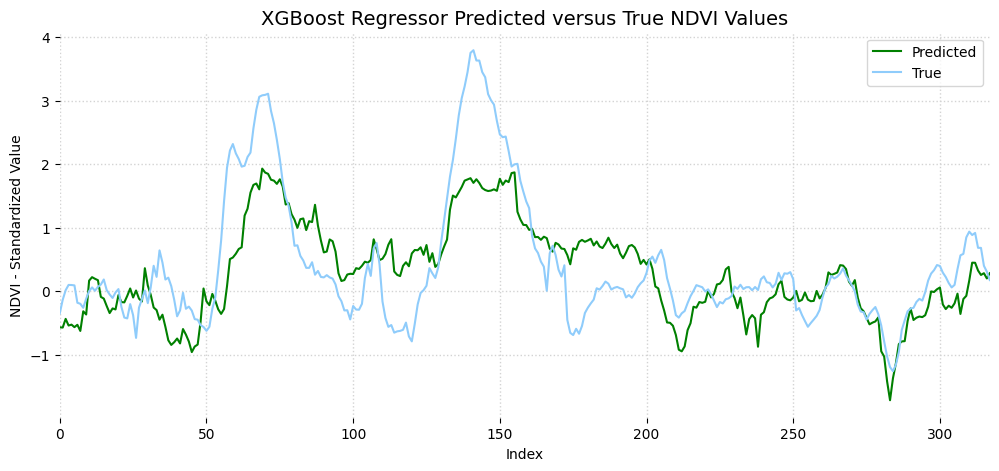

In [ ]:
# Set figure size
plt.figure(figsize=(12, 5))

# Plot the predicted values  in blue
plt.plot(xg_y_pred, label='Predicted', color='green')

# Plot the true values (`y_test`) in red
plt.plot(y_test, label='True', color='#8fccfb')

# Set x-axis limit to start and stop with the data
plt.xlim(0, len(xg_y_pred)-1)

# Add labels and legend
plt.xlabel('Index')
plt.ylabel('NDVI - Standardized Value')
plt.title("XGBoost Regressor Predicted versus True NDVI Values", fontsize=14)
plt.legend()

# Remove the border around the plot
plt.box(False)

# Set the grid to be drawn below the bars
plt.gca().set_axisbelow(True)

# Add a light grid in the background
plt.grid(color='lightgray', linestyle=':', linewidth=1)

# Show the plot
plt.show()

In [ ]:
# # ETR
# # Define the ExtraTreesRegressor model
# et_reg = ExtraTreesRegressor(bootstrap=False,
#                                max_depth=18,
#                                max_features=1.0,
#                                min_samples_leaf=1,
#                                min_samples_split=2,
#                                n_estimators=900)

# # Fit the model to the training data
# et_reg.fit(x_train, y_train)

# # Save the model for reproducibility
# dump(et_reg, '/content/drive/MyDrive/School/M.S./Courses/Capstone/Colab/Data/Models/et_reg.joblib') 

In [ ]:
# Load the model
et_reg = load('/content/drive/MyDrive/School/M.S./Courses/Capstone/Colab/Data/Models/et_reg.joblib') 

# Use the trained model to make predictions on the test data
et_y_pred = et_reg.predict(x_test)

# Calculate the model performance metrics on the test data
mse = mean_squared_error(y_test, et_y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, et_y_pred)

print('Mean Squared Error:', mse)
print('Root Mean Squared Error:', rmse)
print('R-squared:', r2)

Mean Squared Error: 0.5402633468681065
Root Mean Squared Error: 0.7350260858419289
R-squared: 0.48103437242390656


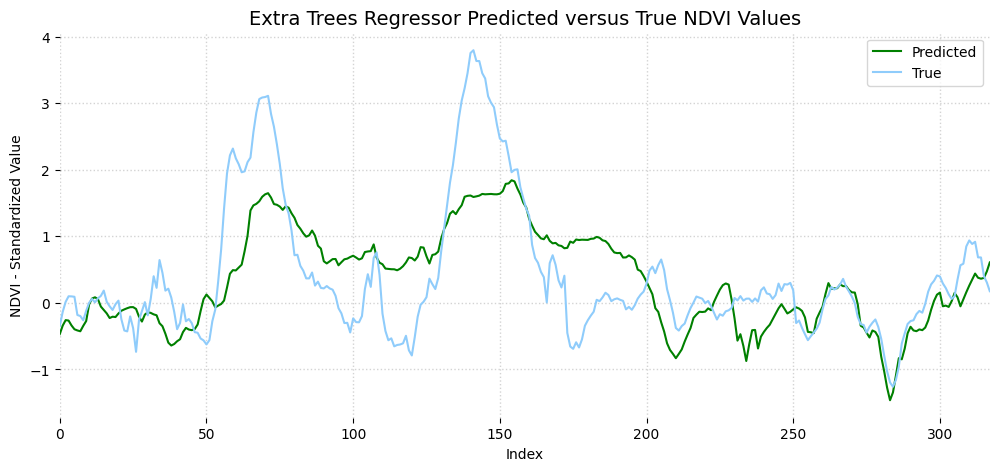

In [ ]:
# Set figure size
plt.figure(figsize=(12, 5))

# Plot the predicted values (`y_pred`) in blue
plt.plot(et_y_pred, label='Predicted', color='green')

# Plot the true values (`y_test`) in red
plt.plot(y_test, label='True', color='#8fccfb')

# Set x-axis limit to start and stop with the data
plt.xlim(0, len(et_y_pred)-1)

# Add labels and legend
plt.xlabel('Index')
plt.ylabel('NDVI - Standardized Value')
plt.title("Extra Trees Regressor Predicted versus True NDVI Values", fontsize=14)
plt.legend()

# Remove the border around the plot
plt.box(False)

# Set the grid to be drawn below the bars
plt.gca().set_axisbelow(True)

# Add a light grid in the background
plt.grid(color='lightgray', linestyle=':', linewidth=1)

# Show the plot
plt.show()

# **Feature Importance**

Feature Importance Ranking:
PDSI : 0.26328903
SPI90 : 0.16858692
SWE : 0.10683035
SPI180 : 0.09074661
PalmerZ : 0.08613881
SPEI180 : 0.05696536
SPEI90 : 0.04005032
EDDI90 : 0.03186807
EDDI180 : 0.030120095
Precip : 0.026700431
EDDI30 : 0.022464998
SPEI30 : 0.020582987
SPI30 : 0.019669998
Tmin : 0.018245744
Tmax : 0.01774028


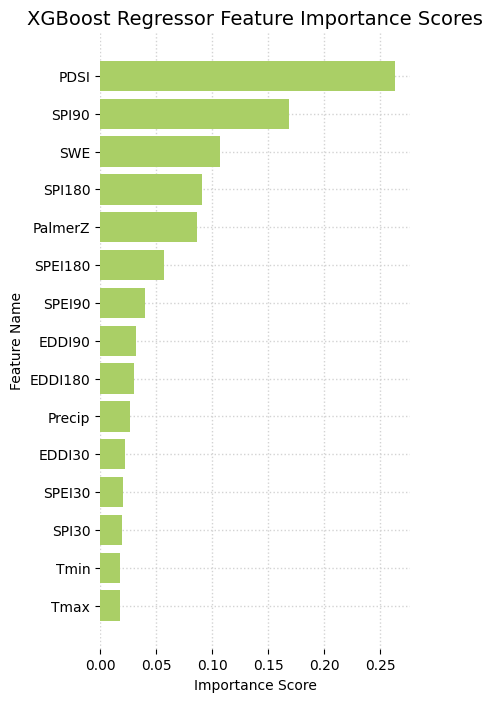

In [ ]:
# XGB
# Get feature importance scores
importance = xg_reg.feature_importances_

# Create a list of feature names
features = list(normalized_df.columns[1:16])

# Create a dictionary of feature importance scores and feature names
feature_importance = dict(zip(features, importance))

# Sort the dictionary by feature importance scores in descending order
sorted_feature_importance = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)

# Print the feature importance ranking
print("Feature Importance Ranking:")
for feature, importance_score in sorted_feature_importance:
    print(feature, ":", importance_score)

# Create a list of feature names and importance scores, in reverse order
features = [x[0] for x in reversed(sorted_feature_importance)]
importance_scores = [x[1] for x in reversed(sorted_feature_importance)]

# Set figure size
plt.figure(figsize=(4, 8))

# Create a horizontal bar chart
plt.barh(features, importance_scores, color='#aacf66')

# Add a title and axis labels
plt.title('XGBoost Regressor Feature Importance Scores', fontsize=14)
plt.xlabel('Importance Score')
plt.ylabel('Feature Name')

# Remove the border around the plot
plt.box(False)

# Set the grid to be drawn below the bars
plt.gca().set_axisbelow(True)

# Add a light grid in the background
plt.grid(color='lightgray', linestyle=':', linewidth=1)


# Display the chart
plt.show()

Feature Importance Ranking:
PDSI : 0.19120152551976133
SPI90 : 0.16050186495048738
SWE : 0.13659858893394305
SPI180 : 0.10493978165488277
SPEI180 : 0.07373890525482399
SPEI90 : 0.06564250243215208
PalmerZ : 0.06288709590672426
EDDI180 : 0.0357280059077054
EDDI90 : 0.034762539714375415
Precip : 0.026266513349394113
EDDI30 : 0.02603902177317938
Tmin : 0.022848615896761636
SPEI30 : 0.020665815586437958
SPI30 : 0.019453535729509787
Tmax : 0.018725687389861443


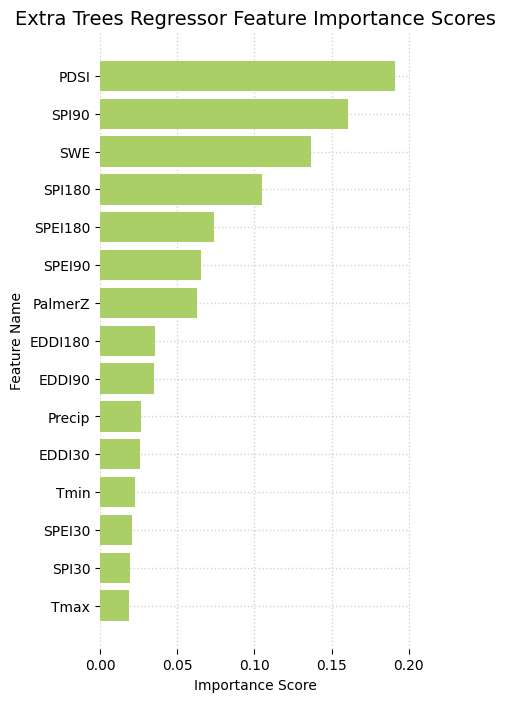

In [ ]:
# ETR
# Get feature importance scores
importance = et_reg.feature_importances_

# Create a list of feature names
features = list(normalized_df.columns[1:16])

# Create a dictionary of feature importance scores and feature names
feature_importance = dict(zip(features, importance))

# Sort the dictionary by feature importance scores in descending order
sorted_feature_importance = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)

# Print the feature importance ranking
print("Feature Importance Ranking:")
for feature, importance_score in sorted_feature_importance:
    print(feature, ":", importance_score)

# Create a list of feature names and importance scores, in reverse order
features = [x[0] for x in reversed(sorted_feature_importance)]
importance_scores = [x[1] for x in reversed(sorted_feature_importance)]

# Set figure size
plt.figure(figsize=(4, 8))

# Create a horizontal bar chart
plt.barh(features, importance_scores, color='#aacf66')

# Add a title and axis labels
plt.title('Extra Trees Regressor Feature Importance Scores', fontsize=14)
plt.xlabel('Importance Score')
plt.ylabel('Feature Name')

# Remove the border around the plot
plt.box(False)

# Set the grid to be drawn below the bars
plt.gca().set_axisbelow(True)

# Add a light grid in the background
plt.grid(color='lightgray', linestyle=':', linewidth=1)

# Display the chart
plt.show()

# **XAI**

In [ ]:
#create a feature name variable that should match the below
feature_names = ['SWE', 'Min Temp', 'Max Temp',
       'Precipitation', 'PDSI', 'EDDI 30-Day',
       'EDDI 90-Day', 'EDDI 180-Day', 'SPEI 30-Day',
       'SPEI 90-Day', 'SPEI 180-Day', 'SPI 30-Day',
       'SPI 90-Day', 'SPI 180-Day', 'Palmer Z']

normalized_df.columns[1:16]

Index(['SWE', 'Tmin', 'Tmax', 'Precip', 'PDSI', 'EDDI30', 'EDDI90', 'EDDI180',
       'SPEI30', 'SPEI90', 'SPEI180', 'SPI30', 'SPI90', 'SPI180', 'PalmerZ'],
      dtype='object')

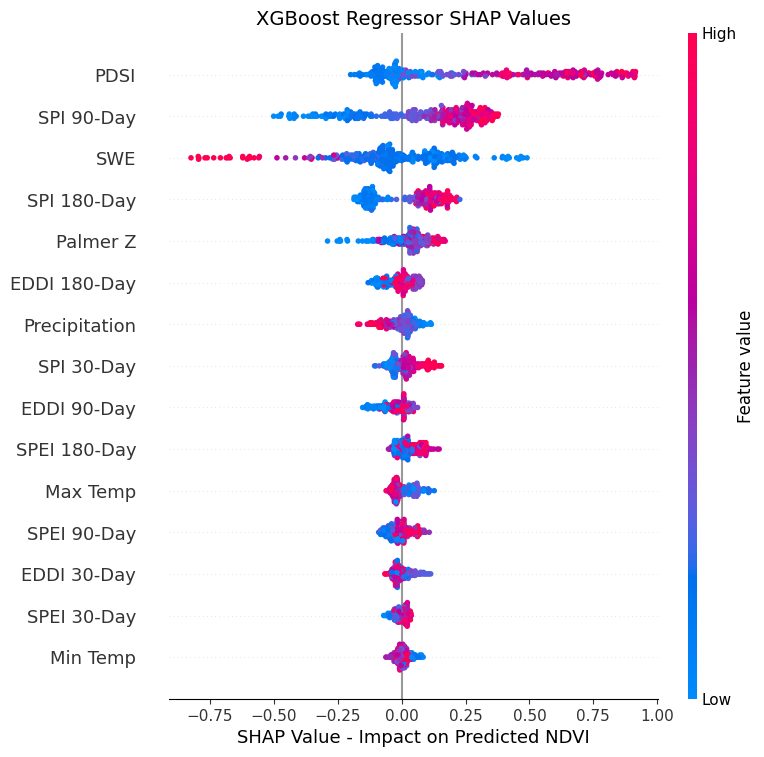

In [ ]:
# Load the model
xg_reg = load('/content/drive/MyDrive/School/M.S./Courses/Capstone/Colab/Data/Models/xgb_reg.joblib') 

# Use the model to make predictions
xg_y_pred = xg_reg.predict(x_test)

# Explain results using SHAP
xg_explainer = shap.Explainer(xg_reg)
xg_shap_values = xg_explainer(x_test)

# Summary plot
shap.summary_plot(xg_shap_values, features=x_test, feature_names=feature_names, show=False)
plt.title("XGBoost Regressor SHAP Values", fontsize = 14)
plt.xlabel('SHAP Value - Impact on Predicted NDVI')
plt.show()

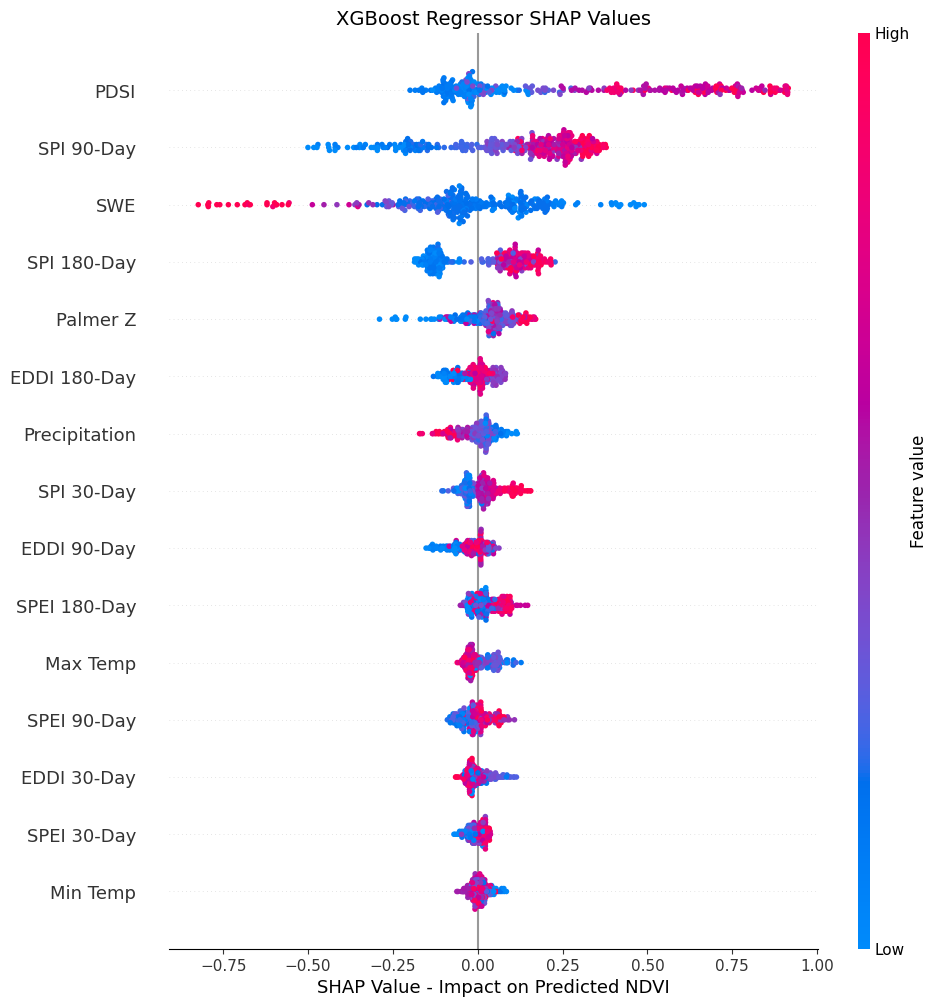

In [ ]:
# Summary plot
shap.summary_plot(xg_shap_values, features=x_test, feature_names=feature_names, show=False, plot_size=(10, 10))
plt.title("XGBoost Regressor SHAP Values", fontsize = 14)
plt.xlabel('SHAP Value - Impact on Predicted NDVI')
plt.show()

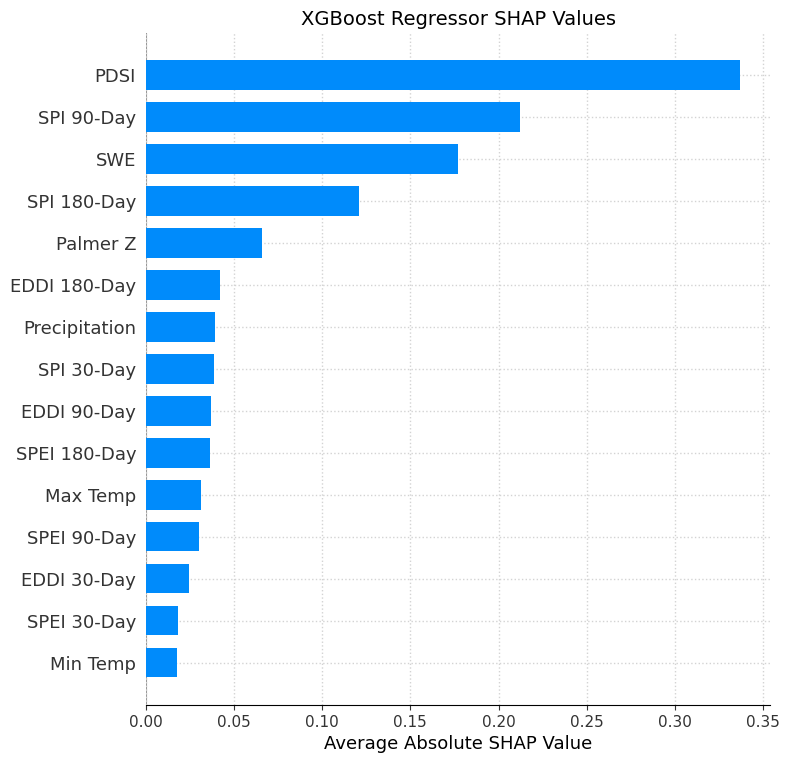

In [ ]:
# create a bar plot showing the above
shap.summary_plot(xg_shap_values, features=x_test, feature_names=feature_names,plot_type="bar", show=False)
plt.title("XGBoost Regressor SHAP Values", fontsize = 14)
plt.xlabel('Average Absolute SHAP Value')

# Set the grid to be drawn below the bars
plt.gca().set_axisbelow(True)

# Add a light grid in the background
plt.grid(color='lightgray', linestyle=':', linewidth=1)

plt.show()

In [ ]:
shap.initjs()
shap.force_plot(xg_explainer.expected_value, xg_shap_values.values, x_test, feature_names=feature_names)

Text(0.5, 0, 'SHAP Value - Impact on Predicted NDVI')

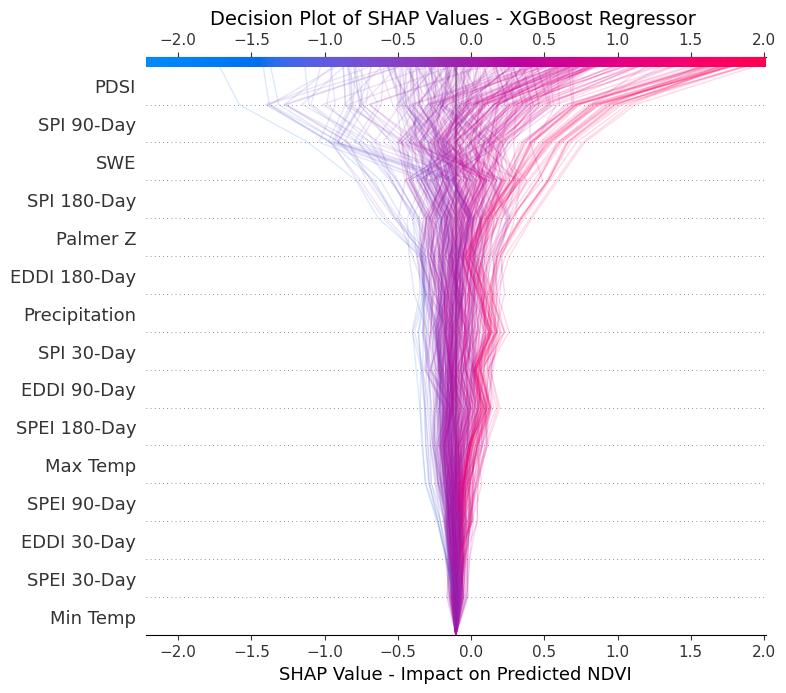

In [ ]:
shap.decision_plot(xg_explainer.expected_value, xg_shap_values.values, feature_names=feature_names, show=False, alpha=0.15)
plt.title("Decision Plot of SHAP Values - XGBoost Regressor ", fontsize = 14)
plt.xlabel('SHAP Value - Impact on Predicted NDVI')

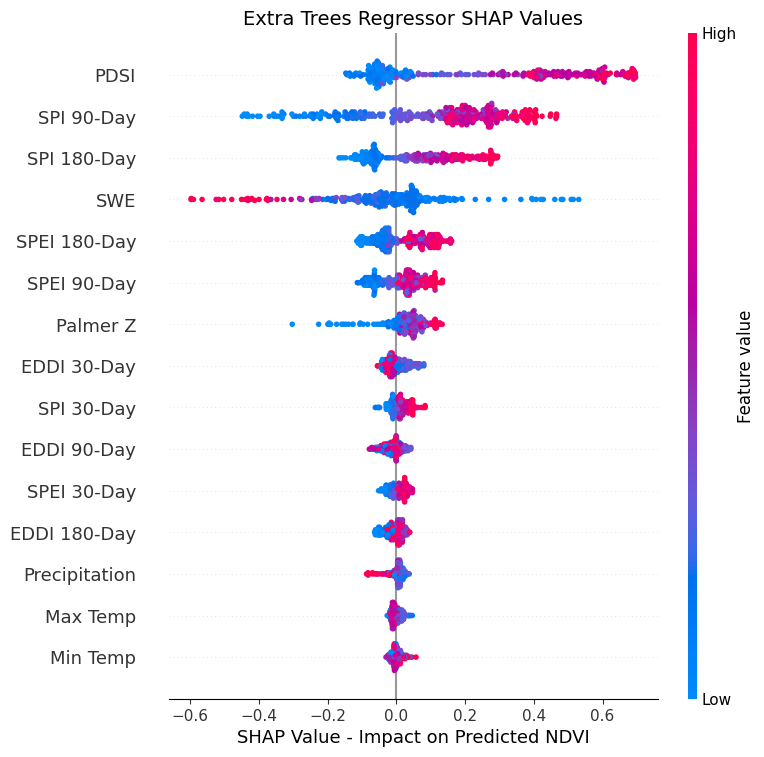

In [ ]:
# Load the model
et_reg = load('/content/drive/MyDrive/School/M.S./Courses/Capstone/Colab/Data/Models/et_reg.joblib') 

# Use the model to make predictions
et_y_pred = et_reg.predict(x_test)

# Explain results using SHAP
et_explainer = shap.Explainer(et_reg)
et_shap_values = et_explainer(x_test)

# Summary plot
shap.summary_plot(et_shap_values, features=x_test, feature_names=feature_names, show=False)
plt.title("Extra Trees Regressor SHAP Values", fontsize = 14)
plt.xlabel('SHAP Value - Impact on Predicted NDVI')
plt.show()

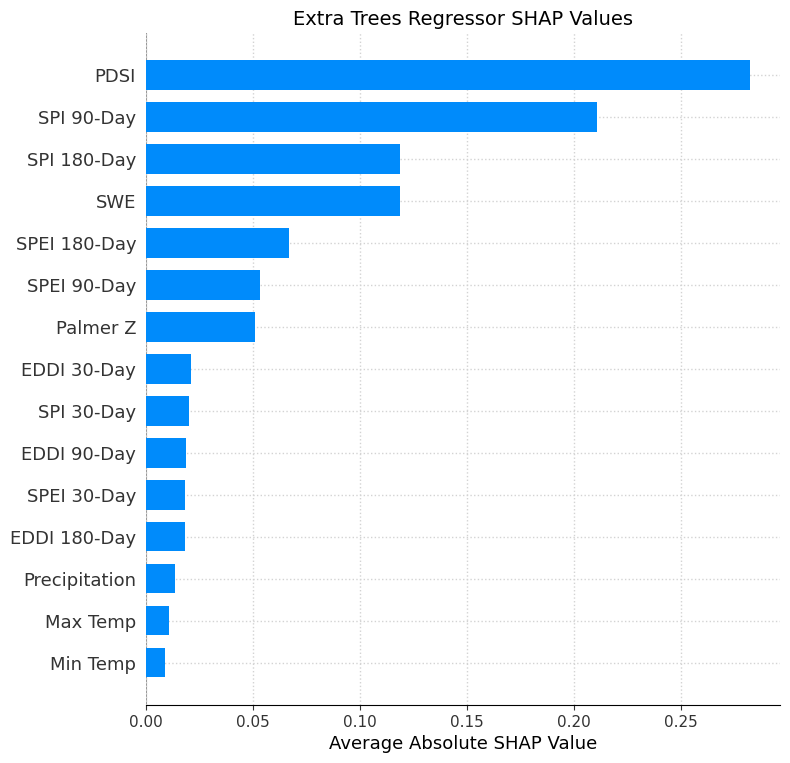

In [ ]:
# create a bar plot showing the above
shap.summary_plot(et_shap_values, features=x_test, feature_names=feature_names,plot_type="bar", show=False)
plt.title("Extra Trees Regressor SHAP Values", fontsize = 14)
plt.xlabel('Average Absolute SHAP Value')

# Set the grid to be drawn below the bars
plt.gca().set_axisbelow(True)

# Add a light grid in the background
plt.grid(color='lightgray', linestyle=':', linewidth=1)

plt.show()

In [ ]:
shap.initjs()
shap.force_plot(et_explainer.expected_value, et_shap_values.values, x_test, feature_names=feature_names)

Text(0.5, 0, 'SHAP Value - Impact on Predicted NDVI')

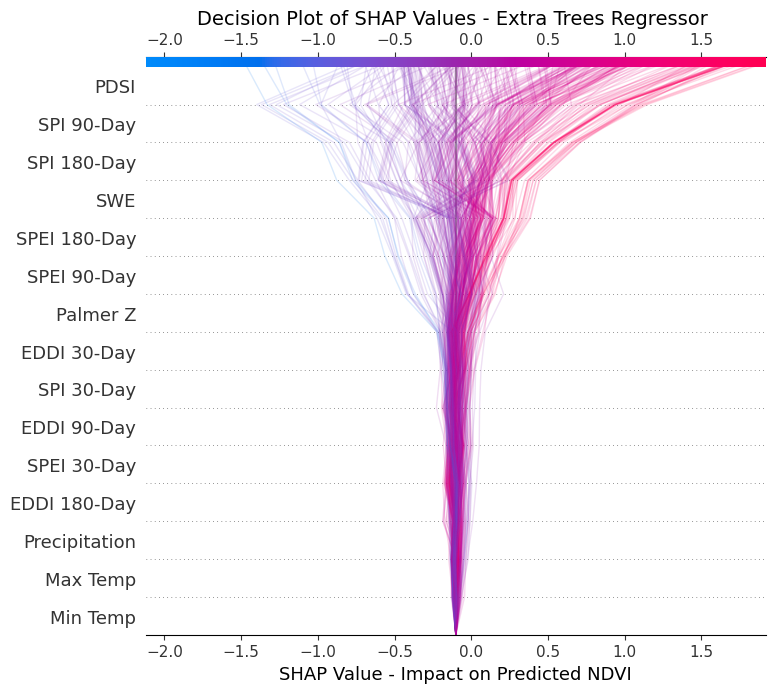

In [ ]:
shap.decision_plot(et_explainer.expected_value, et_shap_values.values, feature_names=feature_names, show=False, alpha=0.15)
plt.title("Decision Plot of SHAP Values - Extra Trees Regressor ", fontsize = 14)
plt.xlabel('SHAP Value - Impact on Predicted NDVI')